In [1]:
import matplotlib.pyplot as plt
import numpy as np
import util

from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot

plt.style.use('ggplot')

In [2]:
# get colors from style scheme
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']                       
print('\n'.join(color for color in colors)) 

#E24A33
#348ABD
#988ED5
#777777
#FBC15E
#8EBA42
#FFB5B8


In [3]:
# Data Nissan leaf

# Rolling Resistance
A = 133.3 # N
# Rotational Losses
B = 0.7094 # Ns/m
# Drag
C = 0.491 # Ns2/m2
# Mass
m = 1645 # kg
# Rated Torque
t_m_r = 254 # Nm
# Rated Power
p_m_r = 80 * 1000 # w
# Transmission ratio
tau_g = 1/8.19
# Transmission Efficiency
eta_g = 0.97 
# Wheen Radius
r_w = 0.315 # m

# Additional
g = 9.81 # m/s2

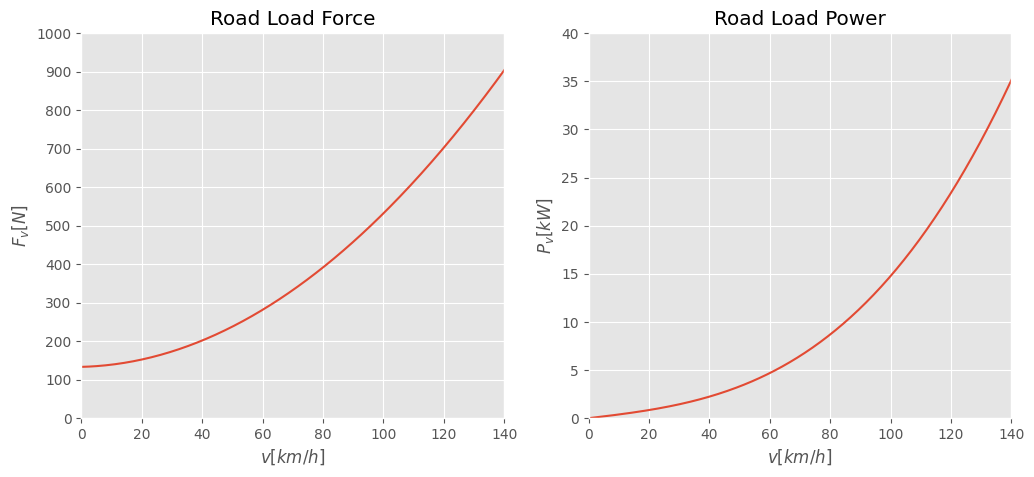

In [4]:
# ROAD LOAD FORCE AND POWER

# Make data
# Velocity
v = np.linspace(0, 140, 1000) # [m/s]
# Road Load Force
f_v = util.road_load_force(A, B, C, v) # [N]
# Road Load Power
p_v = util.road_load_power(v, f_v) # [W]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(v * 3.6, f_v)
ax1.set(
    xlabel = r'$v  [km/h]$',
    ylabel = r'$F_v [N]$',
    title = 'Road Load Force',
    xlim = (0, 140),
    ylim = (0, 1000),
    yticks = np.arange(0, 1100, 100),
)

ax2.plot(v * 3.6, p_v / 1000)
ax2.set(
    xlabel = r'$v  [km/h]$',
    ylabel = r'$P_v [kW]$',
    title = 'Road Load Power',
    xlim = (0, 140),
    ylim = (0, 40),
)   

plt.show()

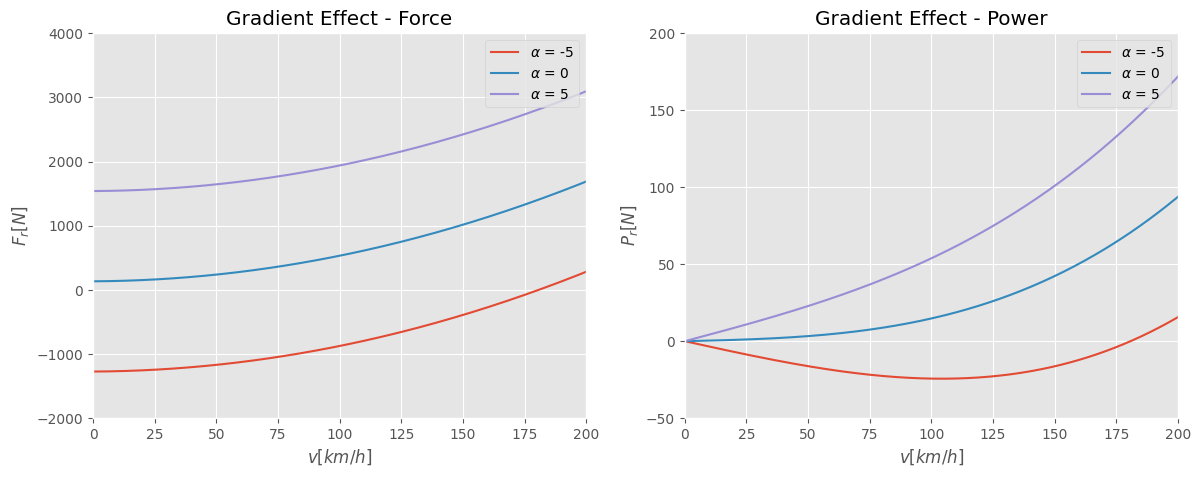

In [5]:
# GRADIENT EFFECT

# Define parameters
alphas = [-5, 0, 5]  # degrees 
v = np.linspace(0, 200, 1000) # [m/s]
f_r = [util.gradient_force(alpha, A, B, C, v, m, g) for alpha in alphas] # [N]
p_r = [util.gradient_power(alpha, A, B, C, v, m, g) for alpha in alphas] # [W]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(v * 3.6, f_r[0], label=r'$\alpha$ = -5')
ax1.plot(v * 3.6, f_r[1], label=r'$\alpha$ = 0')
ax1.plot(v * 3.6, f_r[2], label=r'$\alpha$ = 5')
ax1.set(
    title = 'Gradient Effect - Force',
    xlabel = r'$v  [km/h]$',
    ylabel = r'$F_r [N]$',
    xlim = (0, 200),
    ylim = (-2000, 4000),
)
ax1.legend(loc='upper right')

ax2.plot(v * 3.6, p_r[0] / 1000, label=r'$\alpha$ = -5')
ax2.plot(v * 3.6, p_r[1] / 1000, label=r'$\alpha$ = 0')
ax2.plot(v * 3.6, p_r[2] / 1000, label=r'$\alpha$ = 5')
ax2.set(
    title = 'Gradient Effect - Power',
    xlabel = r'$v  [km/h]$',
    ylabel = r'$P_r [N]$',
    xlim = (0, 200),
    ylim = (-50, 200),
)
ax2.legend(loc='upper right')

plt.show()

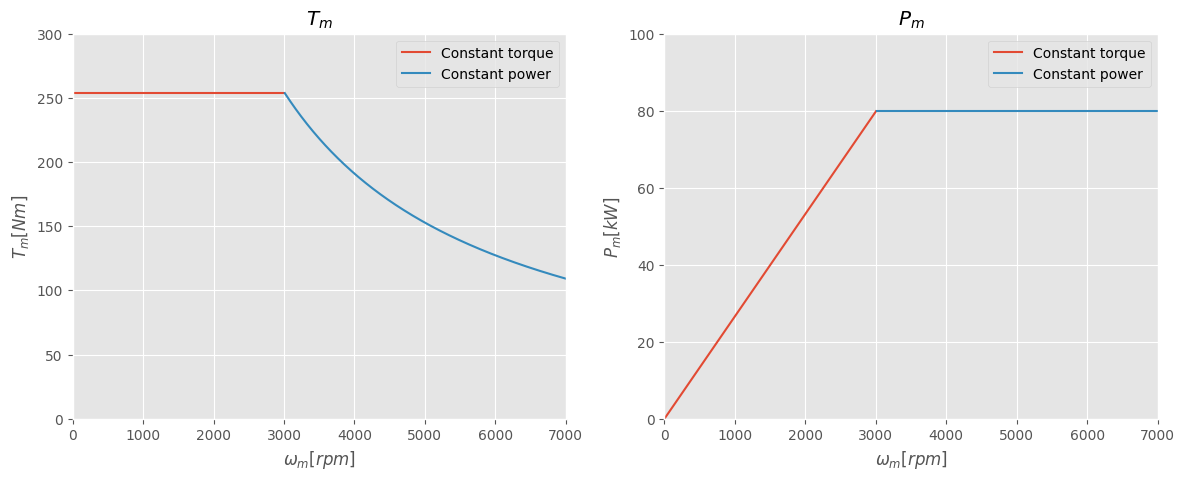

In [6]:
# Motor characteristic curve

# Speed range
w_m = np.linspace(0.1, 1000, 1000) # [rad/s]
# Rated speed
w_m_r = util.rated_nominal_speed(p_m_r, t_m_r) # Given
# Constant toque
t_m = util.constant_torque_mode(w_m, w_m_r, t_m_r, p_m_r)
# Constant power
p_m = util.constant_power_mode(w_m, w_m_r, t_m_r, p_m_r)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(
    util.rads_to_rpm(w_m[w_m <= w_m_r]),
    np.full_like(w_m[w_m <= w_m_r], t_m[w_m <= w_m_r]),
    label='Constant torque',
)
ax1.plot(
    util.rads_to_rpm(w_m[w_m > w_m_r]),
    t_m[w_m > w_m_r],
    label='Constant power',
)
ax1.set(
    title = r'$T_m$',
    xlabel = r'$\omega_m  [rpm]$',
    ylabel = r'$T_m [Nm]$',
    xlim = (0, 7000),
    ylim = (0, 300),
)
ax1.legend(loc = 'upper right')

ax2.plot(
    util.rads_to_rpm(w_m[w_m <= w_m_r]),
    p_m[w_m <= w_m_r] / 1000,
    label='Constant torque',
)
ax2.plot(
    util.rads_to_rpm(w_m[w_m > w_m_r]),
    np.full_like(w_m[w_m > w_m_r], p_m[w_m > w_m_r]) / 1000,
    label='Constant power',
)
ax2.set(
    title = r'$P_m$',
    xlabel = r'$\omega_m  [rpm]$',
    ylabel = r'$P_m [kW]$',
    xlim = (0, 7000),
    ylim = (0, 100),
)
ax2.legend(loc = 'upper right')

plt.show()

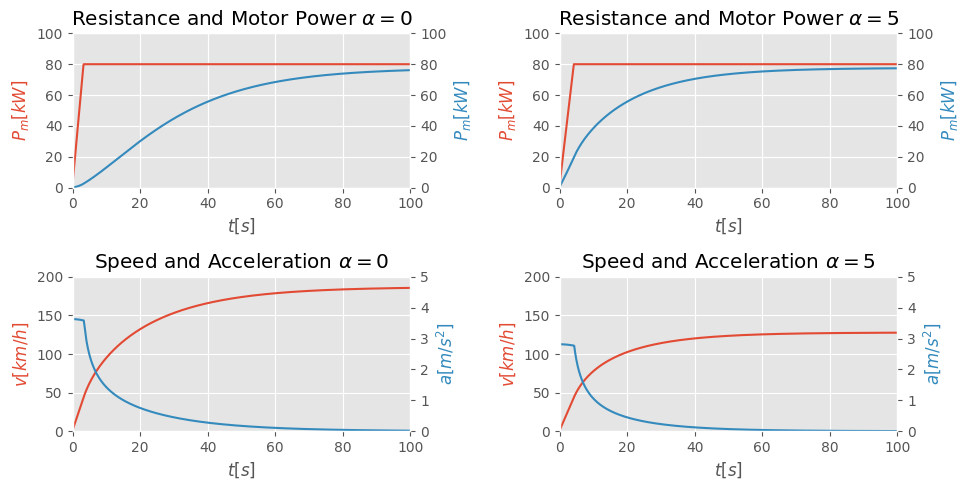

In [7]:
# Vehicle Acceleration

# Define parameters
# Angles
alphas = [0, 5] # Degrees
# Rated nominal speed
w_m_r = util.rated_nominal_speed(p_m_r, t_m_r) # Given
# Initial conditions
t_max = 100 # [s]
dt = 0.1    
t_vals = np.arange(0, t_max, dt)
# Initialize Velocity and Acceleration empty list
v_vals = []
acc_vals = []

# Numeric integration in t
# Let v=0 at time t0
for alpha in alphas:
    v = 0.1
    for _ in range(len(t_vals)):
        w_m = v / (r_w * tau_g) # v -> angular speed
        t_m = util.constant_torque_mode(w_m, w_m_r, t_m_r, p_m_r)
        f_m = (eta_g * t_m) / (r_w * tau_g)
        f_r = util.gradient_force(alpha, A, B, C, v, m, g)
        # acceleration
        acc = (f_m - f_r) / (m + 0.05 * m)
        # velocity
        v = v + acc * dt
        
        v_vals.append(v)
        acc_vals.append(acc)

# separate vector into correspondent vals for each angle
v_vals = np.array(v_vals)
acc_vals = np.array(acc_vals)
v_vals_0 = v_vals[:len(t_vals)]
v_vals_5 = v_vals[len(t_vals):]
a_vals_0 = acc_vals[:len(t_vals)]
a_vals_5 = acc_vals[len(t_vals):]
# P = F*v
w_m_vals = (v_vals / (r_w * tau_g))
w_m_0 = w_m_vals[:len(t_vals)]
w_m_5 = w_m_vals[len(t_vals):]
p_m_0 = util.constant_power_mode(w_m_0, w_m_r, t_m_r, p_m_r)
p_m_5 = util.constant_power_mode(w_m_5, w_m_r, t_m_r, p_m_r)
p_r_0 = util.gradient_power(alphas[0], A, B, C, v_vals_0, m, g)
p_r_5 = util.gradient_power(alphas[1], A, B, C, v_vals_5, m, g)  


# plot
fig = plt.figure(figsize=(10,5))
plt.style.use('ggplot')

ax1 = host_subplot(221)
ax2 = host_subplot(222)
ax3 = host_subplot(223)
ax4 = host_subplot(224)

ax1_1 = ax1.twinx()
ax1.set(
    title=r'Resistance and Motor Power $\alpha = 0$',
    xlabel=r'$t[s]$',
    ylabel=r'$P_m[kW]$',
    ylim=(0, 100),
)
ax1_1.set(
    ylabel=r'$P_m[kW]$',
    ylim=(0, 100),
)
p1, = ax1.plot(t_vals, p_m_0 / 1000)
p2, = ax1_1.plot(t_vals, p_r_0 / 1000)
ax1.yaxis.label.set_color(p1.get_color())
ax1_1.yaxis.label.set_color(p2.get_color())

ax2_1 = ax2.twinx()
ax2.set(
    title=r'Resistance and Motor Power $\alpha = 5$',
    xlabel=r'$t[s]$',
    ylabel=r'$P_m[kW]$',
    ylim=(0, 100),
)
ax2_1.set(
    ylabel=r'$P_m[kW]$',
    ylim=(0, 100),
)
p3, = ax2.plot(t_vals, p_m_5 / 1000 )
p4, = ax2_1.plot(t_vals, p_r_5 / 1000)
ax2.yaxis.label.set_color(p3.get_color())
ax2_1.yaxis.label.set_color(p4.get_color())

ax3_1 = ax3.twinx()
ax3.set(
    title=r'Speed and Acceleration $\alpha = 0$',
    xlabel=r'$t[s]$',
    ylabel=r'$v[km/h]$',
    ylim=(0, 200),
)
ax3_1.set(
    ylabel=r'$a[m/s^2]$',
    ylim=(0, 5),
)
ax3_1.grid(False)
p3, = ax3.plot(t_vals, v_vals_0 * 3.6)
p4, = ax3_1.plot(t_vals, a_vals_0)
ax3.yaxis.label.set_color(p3.get_color())
ax3_1.yaxis.label.set_color(p4.get_color())

ax4_1 = ax4.twinx()
ax4.set(
    title=r'Speed and Acceleration $\alpha = 5$',
    xlabel=r'$t[s]$',
    ylabel=r'$v[km/h]$',
    ylim=(0, 200),
)
ax4_1.set(
    ylabel=r'$a[m/s^2]$',
    ylim=(0, 5),
)
ax4_1.grid(False)
p3, = ax4.plot(t_vals, v_vals_5 * 3.6)
p4, = ax4_1.plot(t_vals, a_vals_5)
ax4.yaxis.label.set_color(p3.get_color())
ax4_1.yaxis.label.set_color(p4.get_color())

plt.subplots_adjust(right=0.88)
for ax in fig.get_axes():
    ax.set_xlim(0, 100)
plt.tight_layout()

plt.show()